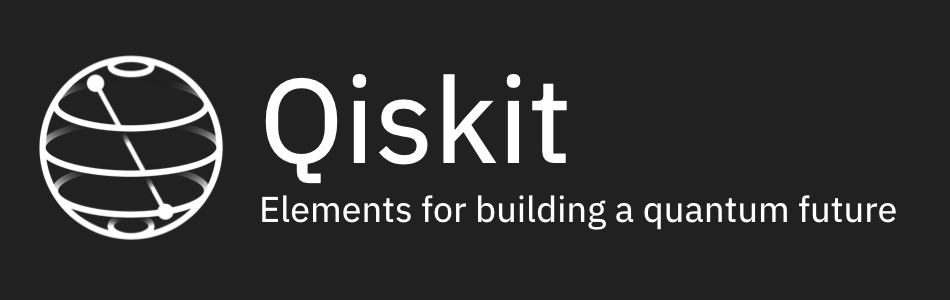

# Uploading a Qiskit runtime program

Here we provide an overview on how to construct and upload a runtime program. A runtime program is a piece of Python code that lives in the cloud and can be invoked by passing in just its parameters. Runtime programs are private by default, which means only you can see and access your programs. Some authorized users can also mark their programs as public, making them visible and accessible by everyone.

## Constructing a runtime program

Below is a template of a runtime program. You can find the template file in the 
[qiskit-ibm-runtime](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/qiskit_ibm_runtime/program/program_template.py) repository.

In [1]:
import sys
import json

from qiskit_ibm_runtime.program import UserMessenger, ProgramBackend


def program(backend: ProgramBackend, user_messenger: UserMessenger, **kwargs):
    """Function that does classical-quantum calculation."""
    # UserMessenger can be used to publish interim results.
    user_messenger.publish("This is an interim result.")
    return "final result"


def main(backend: ProgramBackend, user_messenger: UserMessenger, **kwargs):
    """This is the main entry point of a runtime program.

    The name of this method must not change. It also must have ``backend``
    and ``user_messenger`` as the first two positional arguments.

    Args:
        backend: Backend for the circuits to run on.
        user_messenger: Used to communicate with the program user.
        kwargs: User inputs.
    """
    # Massage the input if necessary.
    result = program(backend, user_messenger, **kwargs)
    # Final result can be directly returned
    return result

Each runtime program must have a `main()` function, which serves as the entry point to the program. This function must have `backend` and `user_messenger` as the first two positional arguments:

- `backend` is an instance of [ProgramBackend](https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.runtime.ProgramBackend.html) and has a [run()](https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.runtime.ProgramBackend.run.html#qiskit.providers.ibmq.runtime.ProgramBackend.run) method that can be used to submit circuits.
- `user_messenger` is an instance of [UserMessenger](https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.runtime.UserMessenger.html) and has a [publish()](https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.runtime.UserMessenger.publish.html#qiskit.providers.ibmq.runtime.UserMessenger.publish) method that can be used to send interim and final results to the program user. This method takes a parameter `final` that indicates whether it's a final result. However, it is recommended to return the final result directly from the `main()` function. Currently only final results are stored after a program execution finishes.

There are several runtime program source code in the `program_source` directory in this repository. `program_source/hello_world/hello_world.py` is one of them. It is a sample runtime program that submits random circuits for user-specified iterations:

In [2]:
"""A sample runtime program that submits random circuits for user-specified iterations."""

import random

from qiskit import transpile
from qiskit.circuit.random import random_circuit


def prepare_circuits(backend):
    """Generate a random circuit.

    Args:
        backend: Backend used for transpilation.

    Returns:
        Generated circuit.
    """
    circuit = random_circuit(
        num_qubits=5, depth=4, measure=True, seed=random.randint(0, 1000)
    )
    return transpile(circuit, backend)


def main(backend, user_messenger, **kwargs):
    """Main entry point of the program.

    Args:
        backend: Backend to submit the circuits to.
        user_messenger: Used to communicate with the program consumer.
        kwargs: User inputs.
    """
    iterations = kwargs.pop("iterations", 5)
    for it in range(iterations):
        qc = prepare_circuits(backend)
        result = backend.run(qc).result()
        user_messenger.publish({"iteration": it, "counts": result.get_counts()})

    return "Hello, World!"

## Data serialization

Runtime programs live in the cloud, and JSON is the standard way of passing data to and from cloud services. Therefore, when a user invokes a runtime program, the input parameters must first be serialized into the JSON format  and then deserialized once received by the server. By default, this serialization and deserialization is done automatically using the [RuntimeEncoder](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeEncoder.html#qiskit_ibm_runtime.RuntimeEncoder) and [RuntimeDecoder](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeDecoder.html#qiskit_ibm_runtime.RuntimeDecoder) classes.


### Custom classes

`RuntimeEncoder` and `RuntimeDecoder` only support types commonly used in Qiskit, such as complex numbers and numpy arrays. If your program uses custom Python classes for input or output, these two methods only have partial support for that. 

Your custom class should have the following methods:

- a `to_json()` method that returns a JSON string representation of the object
- a `from_json()` class method that accepts a JSON string and returns the corresponding object. 

When `RuntimeEncoder` serializes a Python object, it checks whether the object has a `to_json()` method. If so, it calls the method to serialize the object. `RuntimeDecoder`, however, does _not_ invoke `from_json()` to convert the data back because it doesn't know how to import your custom class. Therefore the deserialization needs to be done explicitly. 

Here is an example of serializing and deserializing a custom class. First we define the class `MyCustomClass`:

In [3]:
import json


class MyCustomClass:
    def __init__(self, foo, bar):
        self._foo = foo
        self._bar = bar

    def to_json(self):
        """Convert this instance to a JSON string."""
        return json.dumps({"foo": self._foo, "bar": self._bar})

    @classmethod
    def from_json(cls, json_str):
        """Return a MyCustomClass instance based on the input JSON string."""
        return cls(**json.loads(json_str))

Note that it has the `to_json()` method that converts a `MyCustomClass` instance to a JSON string, and a `from_json()` class method that converts a JSON string back to a `MyCustomClass` instance.

Here is how one would use `MyCustomClass` as an **input** to your program:

```
program_inputs = {
    'my_obj': MyCustomClass("my foo", "my bar")
}

options = {"backend_name": "ibmq_qasm_simulator"}
job = service.run(program_id="some-program",
                           options=options,
                           inputs=program_inputs
                          )
```

Since `MyCustomClass` has a `to_json()` method, the method is automatically called to convert the instance to a JSON string when `service.run()` is invoked. 

Your program can then use the `from_json()` method to restore the JSON string back to a `MyCustomClass` instance:

In [4]:
def main(backend, user_messenger, **kwargs):
    """Main entry point of the program."""
    my_obj_str = kwargs.pop("my_obj")
    my_obj = MyCustomClass.from_json(my_obj_str)

Similarly, if you pass a `MyCustomClass` instance as an **output** of your program, it is automatically converted to a JSON string (via the `to_json()` method):

In [5]:
def main(backend, user_messenger, **kwargs):
    """Main entry point of the program."""
    return MyCustomClass("this foo", "that bar")

Now when the user of this program calls `job.result()`, they will receive a JSON string rather than a `MyCustomClass` instance. The user can convert the string back to `MyCustomClass` themselves:

```
output_str = job.result()
output = MyCustomClass.from_json(output_str)
```

Alternatively, you can provide a decoder for the users. Your decoder class should inherit [ResultDecoder](https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.runtime.ResultDecoder.html) and overwrite the `decode()` method:

In [6]:
from qiskit_ibm_runtime.program import ResultDecoder


class MyResultDecoder(ResultDecoder):
    @classmethod
    def decode(cls, data):
        data = super().decoded(data)  # Perform any preprocessing.
        return MyCustomClass.from_json(data)

Your user can then use this `MyResultDecoder` to decode the result of your program:

```
output = job.result(decoder=MyResultDecoder)
```

## Testing your runtime program

You can test your runtime program using a local simulator or a real backend before uploading it. Simply import and invoke the `main()` function of your program and pass the following parameters:

- the `backend` instance you want to use
- a new `UserMessenger` instance.
- program input parameters that are serialized and then deserialized using the correct encoder and decoder. While this may seem redundant, it is to ensure input parameters can be passed to your program properly once it's uploaded to the cloud.


The following example tests the `hello-world` program we saw earlier. It uses the `qasm_simulator` from Qiskit Aer as the test backend. It serializes and deserializes input data using `RuntimeEncoder` and `RuntimeDecoder`, which are the default en/decoders used by runtime.

In [7]:
import sys

sys.path.insert(0, "..")  # Add source_program directory to the path

from program_source.hello_world import hello_world
from qiskit import Aer
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder, UserMessenger

inputs = {"iterations": 3}

backend = Aer.get_backend("qasm_simulator")
user_messenger = UserMessenger()
serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

hello_world.main(backend, user_messenger, **deserialized_inputs)

{"iteration": 0, "counts": {"00011": 10, "00010": 7, "01011": 527, "01010": 480}}
{"iteration": 1, "counts": {"00000": 884, "00110": 140}}
{"iteration": 2, "counts": {"00001": 506, "00011": 518}}


'Hello, World!'

## Defining program metadata

Program metadata helps users to understand how to use your program. It includes:

- `name`: Name of the program.
- `max_execution_time`: Maximum amount of time, in seconds, a program can run before being forcibly terminated.
- `description`: Describes the program.
- `spec`: Detailed information about the program, which includes the following attributes:
    - `backend_requirements`: Describes the backend attributes needed to run the program.
    - `parameters`: Describes the program input parameters as a JSON schema
    - `return_values`: Describes the return values as a JSON schema
    - `interim_results`: Describes the interim results as a JSON schema

When uploading a program, you must specify at least `name`, `max_execution_time`, and `description`. It is strongly encouraged to also specify `parameters`, `return_values`, and `interim_results` within `spec` if the program has them.

Below shows the metadata JSON file of the `hello-world` program as an example:

In [9]:
import os

hello_world_json = os.path.join(
    os.getcwd(), "../../program_source/hello_world/hello_world.json"
)

with open(hello_world_json, "r") as file:
    data = file.read()

print(data)

{
  "name": "hello-world",
  "description": "A sample runtime program.",
  "max_execution_time": 300,
  "spec": {
    "backend_requirements": {
      "min_num_qubits": 5
    },
    "parameters": {
      "$schema": "https://json-schema.org/draft/2019-09/schema",
      "properties": {
        "iterations": {
          "type": "integer",
          "minimum": 0,
          "description": "Number of iterations to run. Each iteration generates a runs a random circuit."
        }
      },
      "required": [
        "iterations"
      ]
    },
    "return_values": {
      "$schema": "https://json-schema.org/draft/2019-09/schema",
      "description": "A string that says 'Hello, World!'.",
      "type": "string"
    },
    "interim_results": {
      "$schema": "https://json-schema.org/draft/2019-09/schema",
      "properties": {
        "iteration": {
          "type": "integer",
          "description": "Iteration number."
        },
        "counts": {
          "description": "Histogram data

## Uploading a program

You can use the [QiskitRuntimeService.upload_program()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.upload_program) method to upload your program. In the example below, the program data lives in the file `hello_world.py`, and its metadata, as described above, is in `hello_world.json`. 

In [10]:
import os
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

hello_world_data = os.path.join(
    os.getcwd(), "../../program_source/hello_world/hello_world.py"
)
hello_world_json = os.path.join(
    os.getcwd(), "../../program_source/hello_world/hello_world.json"
)

program_id = service.upload_program(data=hello_world_data, metadata=hello_world_json)
print(program_id)

hello-world-m92QdGKYro


`upload_program()` returns a program ID, which uniquely identifies the program. It is derived from the program name, usually with a randomly-generated suffix. Program ID is needed to invoke the program.

## Updating a program

You can use the [QiskitRuntimeService.update_program()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.update_program.html#qiskit_ibm_runtime.QiskitRuntimeService.update_program) method to update the source code and/or metadata of a program:

In [11]:
service.update_program(program_id=program_id, description="A new description.")

This method allows you to make changes to your program while retaining the same program ID.

## Deleting a program

You can use the [QiskitRuntimeService.delete_program()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.delete_program) method to delete a program. Only the person who uploaded the program can delete it. 


In [12]:
service.delete_program(program_id)

## Additional materials

This is an introductory tutorial on creating and uploading a very simple custom program. [sample_vqe_program/qiskit_runtime_vqe_program.ipynb](sample_vqe_program/qiskit_runtime_vqe_program.ipynb) provides a more in-depth tutorial on creating a real-world Qiskit Runtime program.

In [1]:
from qiskit.tools.jupyter import *

%qiskit_copyright